In [1]:
import numpy as np
import pandas as pd 
import tushare as ts

In [2]:
CSI_300_df = ts.get_hs300s()
tickers = CSI_300_df['code'].values  # 转化为列表 002044 000961
new_tickers = []
for i in tickers:
    if i[0] == '0' or i[0] == '3':
        i = i + '.SZ'
    if i[0] == '6':
        i = i + '.SH'
    new_tickers.append(i)   # 601238.SH  002044.SZ
new_tickers
ticker_mod = new_tickers[45]
ticker_mod
    

'600369.SH'

In [3]:
ts.set_token('7c9f5442e7afbee1c52d71c8f3cc1931af510a048a85580a40530639')
pro = ts.pro_api()
df = pro.daily(ts_code = ticker_mod)
df.sort_values('trade_date',ascending = True ,inplace = True)
df.set_index('trade_date',inplace=True)
df


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
20010109,600369.SH,14.50,15.80,14.50,15.28,6.18,9.10,147.2500,421974.82,647667.509
20010110,600369.SH,15.15,15.94,15.12,15.71,15.28,0.43,2.8100,137532.11,214930.814
20010111,600369.SH,15.78,15.90,15.57,15.74,15.71,0.03,0.1900,73269.90,115660.934
20010112,600369.SH,15.75,15.78,15.47,15.49,15.74,-0.25,-1.5900,39876.98,62289.431
20010115,600369.SH,15.32,15.43,14.61,14.69,15.49,-0.80,-5.1600,38408.01,57960.888
...,...,...,...,...,...,...,...,...,...,...
20210201,600369.SH,4.92,4.95,4.74,4.79,4.94,-0.15,-3.0364,314097.00,151384.595
20210202,600369.SH,4.75,4.82,4.75,4.80,4.79,0.01,0.2088,167583.17,80232.548
20210203,600369.SH,4.81,4.85,4.77,4.79,4.80,-0.01,-0.2083,182584.56,87961.637


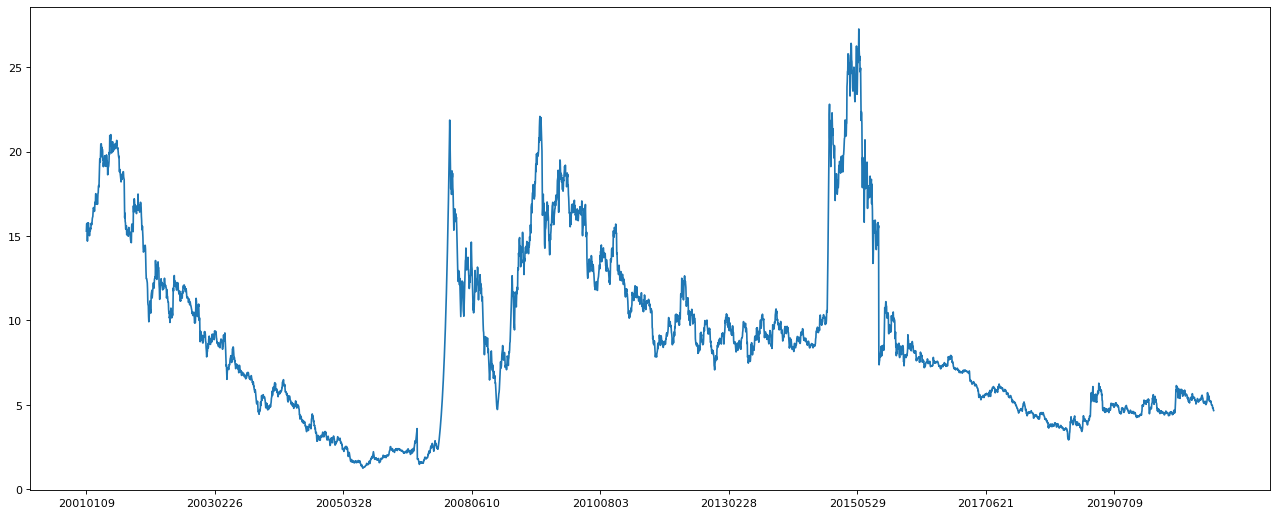

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8),dpi=80)
plt.plot(df['close'])
plt.xticks(ticks=df.index[::500],labels=df.index[::500])
plt.show()

In [5]:
stock = df[['open','high','low','close','vol']]
stock

,open,high,low,close,vol
trade_date,,,,,
20010109,14.50,15.80,14.50,15.28,421974.82
20010110,15.15,15.94,15.12,15.71,137532.11
20010111,15.78,15.90,15.57,15.74,73269.90
20010112,15.75,15.78,15.47,15.49,39876.98
20010115,15.32,15.43,14.61,14.69,38408.01
...,...,...,...,...,...
20210201,4.92,4.95,4.74,4.79,314097.00
20210202,4.75,4.82,4.75,4.80,167583.17
20210203,4.81,4.85,4.77,4.79,182584.56


In [6]:
# 时间点长度
time_stamp = 50
train_num = 3700
# 划分训练集与验证集
train = stock[:train_num + time_stamp]
test = stock[train_num - time_stamp :]


# 归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  
scaled_data = scaler.fit_transform(train)
x_train, y_train = [], []



# 训练集
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, 3])
x_train, y_train = np.array(x_train), np.array(y_train)

# 验证集
scaled_data = scaler.fit_transform(test)
x_test, y_test = [], []
for i in range(time_stamp, len(test)):
    x_test.append(scaled_data[i - time_stamp:i])
    y_test.append(scaled_data[i, 3])
x_test , y_test = np.array(x_test) , np.array(y_test)
print(x_train.shape)
print(x_test.shape)
train.head()
y_test.shape

(3700, 50, 5)
(688, 50, 5)


(688,)

In [7]:
#导入序贯模型
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# 超参数
epochs = 30
batch_size = 20
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim：输入单个样本特征值的维度
# input_length：输入的时间点长度
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
185/185 [==============================] - 8s 22ms/step - loss: 0.0095
Epoch 2/30
185/185 [==============================] - 4s 22ms/step - loss: 8.4852e-04
Epoch 3/30
185/185 [==============================] - 4s 21ms/step - loss: 5.9215e-04
Epoch 4/30
185/185 [==============================] - 4s 22ms/step - loss: 5.9184e-04
Epoch 5/30
185/185 [==============================] - 4s 22ms/step - loss: 4.9659e-04
Epoch 6/30
185/185 [==============================] - 4s 22ms/step - loss: 4.6317e-04
Epoch 7/30
185/185 [==============================] - 4s 24ms/step - loss: 3.1682e-04
Epoch 8/30
185/185 [==============================] - 4s 24ms/step - loss: 3.4612e-04
Epoch 9/30
185/185 [==============================] - 4s 23ms/step - loss: 3.9383e-04
Epoch 10/30
185/185 [==============================] - 4s 23ms/step - loss: 2.9611e-04: 0s - loss: 2.92 - ETA: 0s - loss: 2.
Epoch 11/30
185/185 [==============================] - 4s 23ms/step - loss: 2.5833e-04
Epoch 12/30
185/18

In [8]:
# 预测stock 价格
predict_close_price = model.predict(x_test)
scaler.fit_transform(pd.DataFrame(test['close'].values))
# 反归一化
predict_close_price = scaler.inverse_transform(predict_close_price)
y_test = scaler.inverse_transform([y_test])
# print(y_valid)
# print(closing_price)
rms = np.sqrt(np.mean(np.power((y_test - predict_close_price), 2)))
print(rms)
print(predict_close_price.shape)
print(y_test.shape)

0.9322859803527513
(688, 1)
(1, 688)


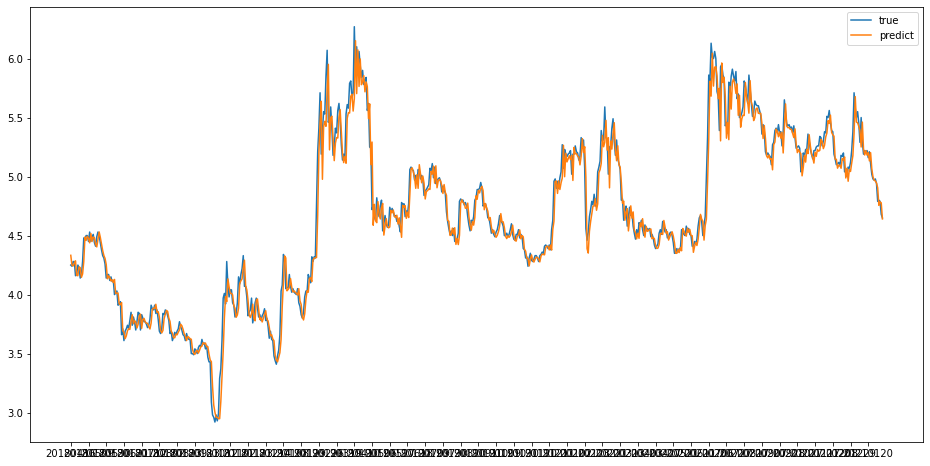

,Predictions,Close,bias
trade_date,,,
20180416,4.332698,4.25,-0.019458
20180417,4.247533,4.24,-0.001777
20180418,4.242653,4.28,0.008726
20180419,4.265899,4.28,0.003295
20180420,4.286043,4.16,-0.030299
...,...,...,...
20210201,4.904835,4.79,-0.023974
20210202,4.756232,4.80,0.009118
20210203,4.785639,4.79,0.000910


In [9]:
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': predict_close_price.reshape(1,-1)[0],
    'Close': y_test[0]
}
data_pd = pd.DataFrame(dict_data)


plt.plot(data_pd['Close'],label = 'true')
plt.plot(data_pd['Predictions'],label = 'predict')
plt.xticks(data_pd.index[::15],df[train_num:].index[::15])
plt.legend()
plt.show()
bias_list = []
data_pd.index = df[train_num:].index
for index , row in data_pd.iterrows():
    bias = (row['Close'] - row['Predictions'])/row['Close']
    bias_list.append(bias)
data_pd['bias'] = bias_list
data_pd.to_csv(ticker_mod + '.csv')
data_pd

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           42400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 72,651
Trainable params: 72,651
Non-trainable params: 0
_________________________________________________________________
